In [85]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
import nibabel as nib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [86]:
def load_fc_matrix(file_path):
    """ Load functional connectivity matrix from a .pconn.nii file. """
    img = nib.load(file_path)
    fc_matrix = img.get_fdata()
    return fc_matrix

def create_knn_graph(fc_matrix, k=5):
    """ Create a graph from a functional connectivity matrix using k-nearest neighbors based on absolute values. """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    
    # For each node, add edges to the k-nearest neighbors based on absolute values of connectivity strengths
    for i in range(n):
        # Sort indices based on the absolute values, get the k highest values indices for each row
        indices = np.argsort(np.abs(fc_matrix[i]))[-k:]
        for j in indices:
            if i != j:  # Ensure no self-loops
                G.add_edge(i, j, weight=fc_matrix[i][j])
    
    return G
def create_threshold_graph(fc_matrix, std_multiplier=2):
    """
    Create a graph from a functional connectivity matrix by adding edges where the 
    absolute connection strength is above a threshold defined as a multiple of the
    standard deviation of the absolute values in the connectivity matrix.
    """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    
    # Calculate the threshold as std_multiplier times the standard deviation of the absolute values
    threshold = std_multiplier * np.std(np.abs(fc_matrix))
    
    # Add nodes
    for i in range(n):
        G.add_node(i)
    
    # Add edges based on the threshold
    for i in range(n):
        for j in range(n):
            if i != j and np.abs(fc_matrix[i, j]) > threshold:  # Avoid self-loops and check threshold
                G.add_edge(i, j, weight=fc_matrix[i, j])
    
    return G

In [87]:
def compute_nnd(graph):
    if not nx.is_connected(graph):
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()
    
    N = len(graph.nodes)
    if N == 1:
        return 0
    
    d = nx.diameter(graph)
    distance_distribution = np.zeros(d + 1)
    
    for node in graph.nodes:
        lengths = nx.single_source_shortest_path_length(graph, node)
        for length in lengths.values():
            if length <= d:
                distance_distribution[length] += 1
    
    distance_distribution /= (N * (N - 1))
    distance_distribution = np.clip(distance_distribution, 1e-10, None)  # Avoid log(0)
    nnd = np.sum(distance_distribution * np.log(1 / distance_distribution)) / np.log(d + 1)
    
    return nnd

def degree_distribution(graph):
    degrees = [degree for node, degree in graph.degree()]
    hist, bins = np.histogram(degrees, bins=range(1, max(degrees) + 2), density=True)
    return hist

def pad_distributions(dist1, dist2):
    max_length = max(len(dist1), len(dist2))
    dist1 = np.pad(dist1, (0, max_length - len(dist1)), 'constant')
    dist2 = np.pad(dist2, (0, max_length - len(dist2)), 'constant')
    return dist1, dist2

def graph_dissimilarity(G, G_prime, w1=1, w2=1, w3=1):
    # Average node distance difference
    mu_G = np.mean([len(nx.single_source_shortest_path_length(G, source=i)) - 1 for i in G.nodes])
    mu_G_prime = np.mean([len(nx.single_source_shortest_path_length(G_prime, source=i)) - 1 for i in G_prime.nodes])
    mu_diff = abs(mu_G - mu_G_prime)
    
    # NND difference
    nnd_G = compute_nnd(G)
    nnd_G_prime = compute_nnd(G_prime)
    nnd_diff = abs(nnd_G - nnd_G_prime)
    
    # Jensen-Shannon divergence for node distance distributions
    degree_dist_G = degree_distribution(G)
    degree_dist_G_prime = degree_distribution(G_prime)
    degree_dist_G, degree_dist_G_prime = pad_distributions(degree_dist_G, degree_dist_G_prime)
    js_divergence = jensenshannon(degree_dist_G, degree_dist_G_prime)
    
    # Jensen-Shannon divergence for complement graphs
    G_c = nx.complement(G)
    G_prime_c = nx.complement(G_prime)
    degree_dist_G_c = degree_distribution(G_c)
    degree_dist_G_prime_c = degree_distribution(G_prime_c)
    degree_dist_G_c, degree_dist_G_prime_c = pad_distributions(degree_dist_G_c, degree_dist_G_prime_c)
    js_divergence_complement = jensenshannon(degree_dist_G_c, degree_dist_G_prime_c)
    
    dissimilarity = (w1 * mu_diff + w2 * nnd_diff + 
                     (w3 / 2) * js_divergence + (w3 / 2) * js_divergence_complement)
    
    return dissimilarity


In [97]:
# Set the behavior path and list all files
behavior_path = '/home/tico/Desktop/master_classes/project/behavior/'
behavior_files = os.listdir(behavior_path)

# Read the first file and initialize the dataframe
behavior_source = pd.read_csv(behavior_path + behavior_files[0], sep='\t')
for behavior_file in behavior_files[1:]:
    curr_behavior_source = pd.read_csv(behavior_path + behavior_file, sep='\t')
    behavior_source = pd.concat([behavior_source, curr_behavior_source], axis=0)

# Select the relevant columns
behavior_source = behavior_source[["session_id", "Group"]]

# Group by 'Group' and sample 3 from each group
bags = behavior_source.groupby('Group').apply(lambda x: x.sample(n=10)).reset_index(drop=True)

# Filter out the samples in 'bags' from 'behavior_source' using 'session_id'
remaining_behavior_source = behavior_source[~behavior_source['session_id'].isin(bags['session_id'])]

# Group by 'Group' and sample 1 from each group
remaining_samples = remaining_behavior_source.groupby('Group').apply(lambda x: x.sample(n=10)).reset_index(drop=True)

# Combine session_ids from bags and remaining_samples to form pconn_files
session_ids = pd.concat([bags['session_id'], remaining_samples['session_id']])
pconn_files = [f"{session_id}.pconn.nii" for session_id in session_ids]

# Directory setup
directory = "/home/tico/Desktop/master_classes/project/BSNIP/pconn"

/tmp/ipykernel_197176/4268299173.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bags = behavior_source.groupby('Group').apply(lambda x: x.sample(n=10)).reset_index(drop=True)
/tmp/ipykernel_197176/4268299173.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  remaining_samples = remaining_behavior_source.groupby('Group').apply(lambda x: x.sample(n=10)).reset_index(drop=True)


In [98]:
# Load graphs
graphs = {}
for file_name in pconn_files:
    file_path = os.path.join(directory, file_name)
    fc_matrix = load_fc_matrix(file_path)
    #graphs[file_name] = create_threshold_graph(fc_matrix, std_multiplier=2)
    graphs[file_name] = create_knn_graph(fc_matrix, k=600)

# Initialize the similarity matrix
similarity_matrix = pd.DataFrame(index=session_ids, columns=session_ids)
count = 0
total = len(remaining_behavior_source)
# Compute the similarities
for i, session_id1 in enumerate(session_ids):
    for j, session_id2 in enumerate(session_ids):
        if j <= i:  # Only compute for the upper triangle and diagonal
            if session_id1 == session_id2:
                similarity_matrix.loc[session_id1, session_id2] = 0  # Self similarity is zero
            else:
                count +=1
                print(f'processing: {session_id1}, {session_id2}, {count}/{total}')
                graph1 = graphs[f"{session_id1}.pconn.nii"]
                graph2 = graphs[f"{session_id2}.pconn.nii"]
                dissimilarity = graph_dissimilarity(graph1, graph2)
                similarity_matrix.loc[session_id1, session_id2] = dissimilarity
                similarity_matrix.loc[session_id2, session_id1] = dissimilarity  # Symmetric assignment
# Sort the matrix
sorted_similarity_matrix = similarity_matrix.sort_index(axis=0).sort_index(axis=1)


processing: S2921ADU1, S4850DVI1, 1/598
processing: S3054NIT1, S4850DVI1, 2/598
processing: S3054NIT1, S2921ADU1, 3/598
processing: S0437DNJ1, S4850DVI1, 4/598
processing: S0437DNJ1, S2921ADU1, 5/598
processing: S0437DNJ1, S3054NIT1, 6/598
processing: S4031EXW1, S4850DVI1, 7/598
processing: S4031EXW1, S2921ADU1, 8/598
processing: S4031EXW1, S3054NIT1, 9/598
processing: S4031EXW1, S0437DNJ1, 10/598
processing: S7239DLH1, S4850DVI1, 11/598
processing: S7239DLH1, S2921ADU1, 12/598
processing: S7239DLH1, S3054NIT1, 13/598
processing: S7239DLH1, S0437DNJ1, 14/598
processing: S7239DLH1, S4031EXW1, 15/598
processing: S4859DPY1, S4850DVI1, 16/598
processing: S4859DPY1, S2921ADU1, 17/598
processing: S4859DPY1, S3054NIT1, 18/598
processing: S4859DPY1, S0437DNJ1, 19/598
processing: S4859DPY1, S4031EXW1, 20/598
processing: S4859DPY1, S7239DLH1, 21/598
processing: S8094BBJ1, S4850DVI1, 22/598
processing: S8094BBJ1, S2921ADU1, 23/598
processing: S8094BBJ1, S3054NIT1, 24/598
processing: S8094BBJ1, S0

In [ ]:
session_ids_groups = pd.concat([bags, remaining_samples])
# Sort by 'group' first and then by 'value' within each group
session_ids_groups_sorted = session_ids_groups.sort_values(by=['Group'])
# Extract the sorted session IDs
sorted_session_ids = session_ids_groups_sorted['session_id']

# Reindex the similarity matrix rows and columns based on the sorted session IDs
sorted_similarity_matrix = sorted_similarity_matrix.reindex(index=sorted_session_ids, columns=sorted_session_ids)
print(session_ids_groups_sorted)

   session_id Group
0   S5935NSK1   BPP
1   S6480AET3   BPP
2   S0156HTH1   BPP
2   S8745IEG1   BPP
1   S9063BKM1   BPP
0   S9888YRS2   BPP
3   S7464HIO1   CON
4   S2514DUC1   CON
5   S9903MNH1   CON
4   S4799MOH1   CON
3   S4985GHI1   CON
5   S7639NEB1   CON
6   S0756ETQ1  SADP
8   S0009QPW3  SADP
8   S2884FKY1  SADP
7   S4491ENT1  SADP
6   S9682VUX1  SADP
7   S9320UHP1  SADP
9   S2632DIN1  SCZP
11  S6645EMI1  SCZP
10  S5753YJP1  SCZP
9   S5279XVU1  SCZP
10  S1772XQR1  SCZP
11  S9879DNR1  SCZP


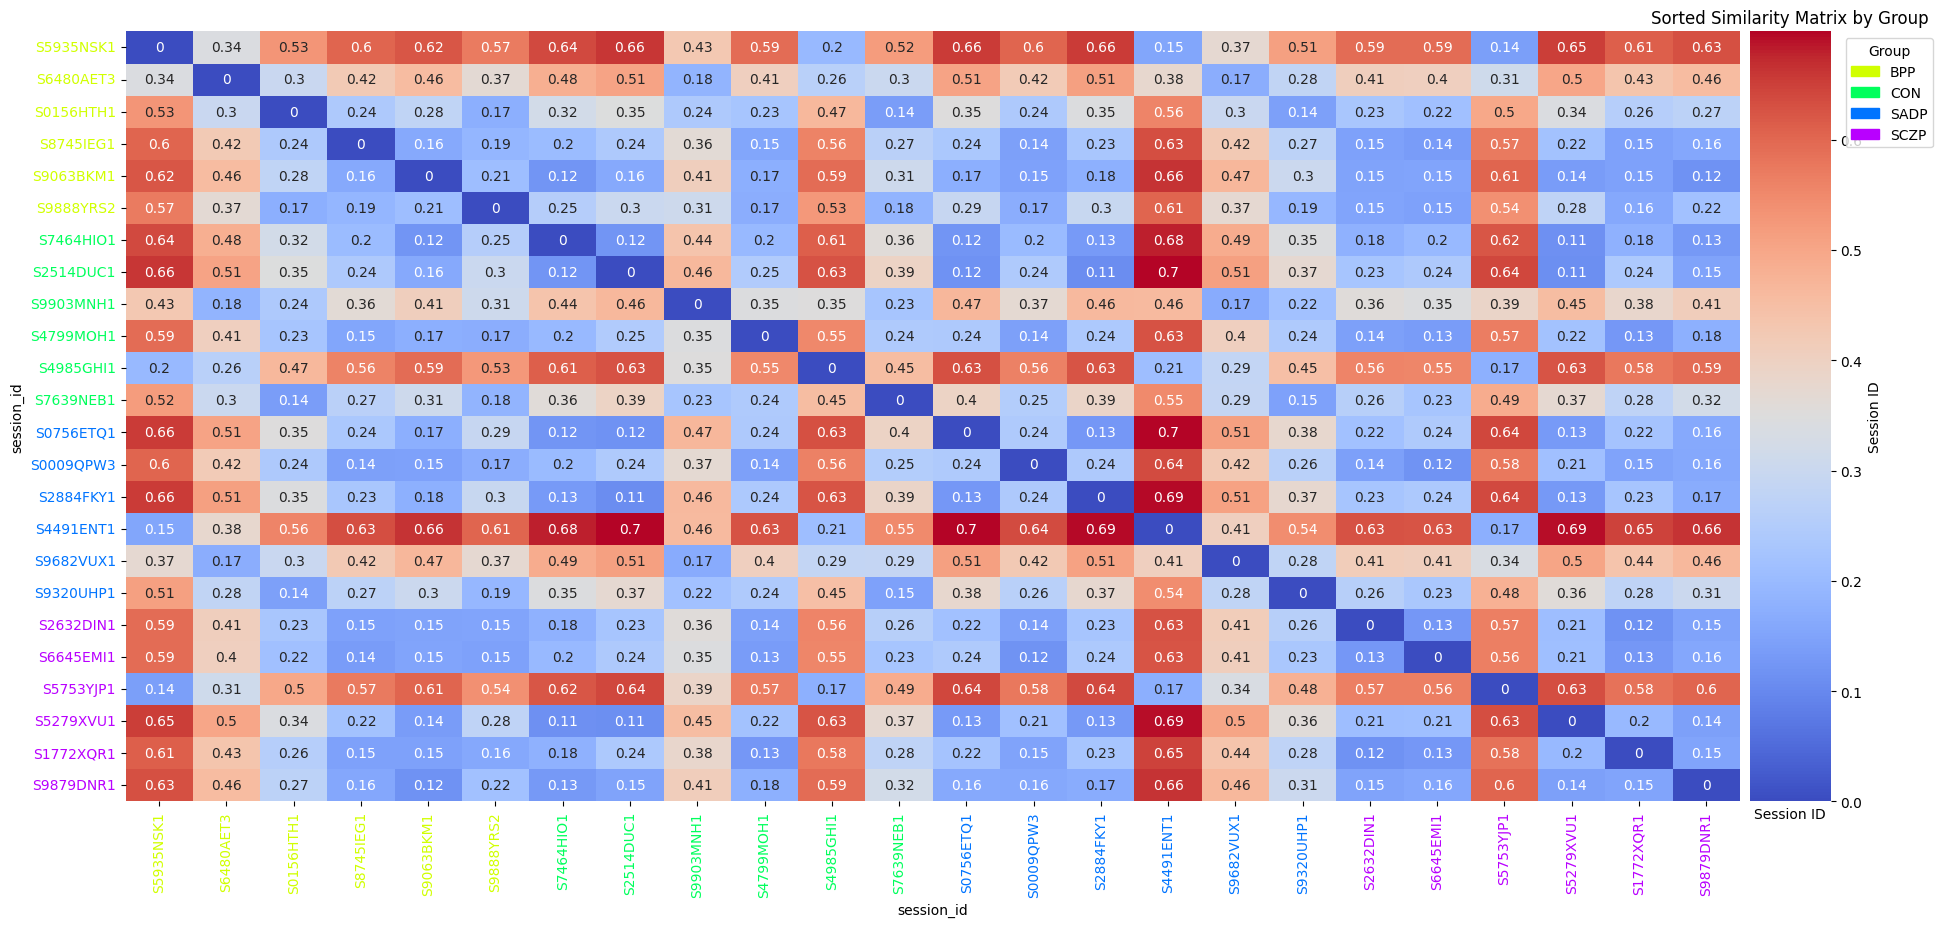

In [ ]:
# Ensure all values in the similarity matrix are numerical
sorted_similarity_matrix = sorted_similarity_matrix.astype(float)

# Extract the sorted session IDs
sorted_session_ids = session_ids_groups_sorted['session_id']

# Reindex the similarity matrix rows and columns based on the sorted session IDs
sorted_similarity_matrix = sorted_similarity_matrix.reindex(index=sorted_session_ids, columns=sorted_session_ids)

# Create a colormap for groups
unique_groups = session_ids_groups_sorted['Group'].unique()
group_colors = {group: color for group, color in zip(unique_groups, sns.color_palette('hsv', len(unique_groups)))}
row_colors = session_ids_groups_sorted['Group'].map(group_colors)

# Plotting the sorted similarity matrix
plt.figure(figsize=(22, 10))

# Create a grid for the main plot and the color bar
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sns.heatmap(sorted_similarity_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Similarity'}, cbar_ax=cax, ax=ax)

# Adding a color bar to represent the groups
for tick_label, tick_color in zip(ax.get_xticklabels(), row_colors):
    tick_label.set_color(tick_color)

for tick_label, tick_color in zip(ax.get_yticklabels(), row_colors):
    tick_label.set_color(tick_color)

# Create legend patches
legend_patches = [Patch(color=color, label=group) for group, color in group_colors.items()]

# Add legend to the plot
plt.legend(handles=legend_patches, title='Group', bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('Sorted Similarity Matrix by Group')
plt.xlabel('Session ID')
plt.ylabel('Session ID')
plt.savefig('plot_D_measure_knn_600.pdf', format='pdf')
plt.show()